In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from classical_code import *
from quantum_code import *
import stim
from scipy.sparse import lil_matrix
import scipy as sp
from ldpc import bposd_decoder, bp_decoder
from tqdm import tqdm
from result_lifetime import Result, save_new_res
# %load_ext snakeviz

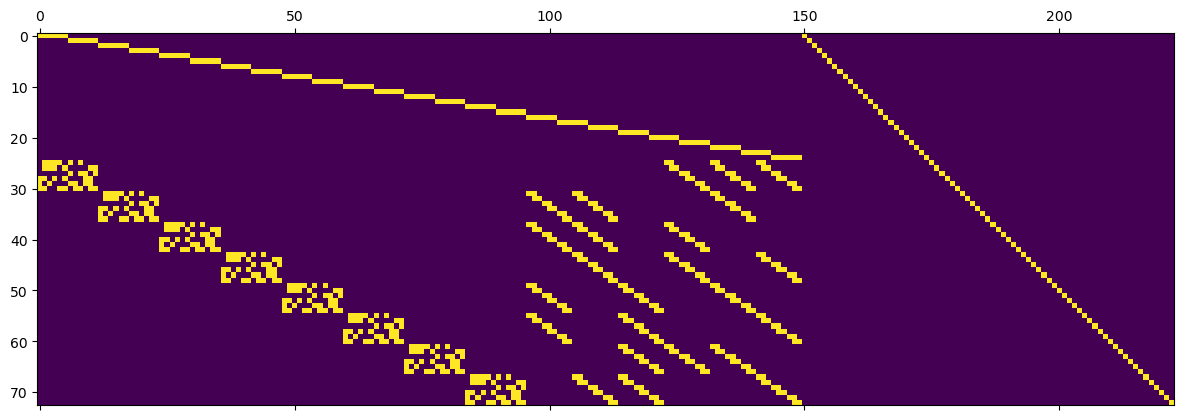

In [2]:
qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_100_4.qcode")

qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_C642_150_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C422_200_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C422_400_8.qcode")


# qcode = read_qcode("../codes/qcodes/HGP_C422_200_4.qcode")
# qcode = read_qcode("./codes/qcodes/HGP_C752_140_4.qcode")

# concatenate_iceberg(qcode, 4, "../codes/qcodes/")
# qcode = read_qcode("../codes/qcodes/HGP_400_16.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_900_36.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C642_1350_36.qcode")

# qcode = read_qcode("../codes/qcodes/HGP_1600_64.qcode")


# concatenate_iceberg2(qcode, 4, "../codes/qcodes")


Hx, Hz, Lx, Lz = qcode.to_numpy()

Hx = np.hstack([Hx, np.eye(Hx.shape[0], dtype=int)])
Hz = np.hstack([Hz, np.eye(Hz.shape[0], dtype=int)])


plt.matshow(Hz)

In [3]:
overlapping_x_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedxm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedxm,qcode.xm):
        if np.any(Hx[i] & Hx[j]): tmp = np.append(tmp, j)
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedzm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedzm,qcode.zm):
        if np.any(Hz[i] & Hz[j]): tmp = np.append(tmp, j)
    overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False, not_overlapping=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])

    if not_overlapping:
        return np.array(list(set(np.arange(qcode.qedxm,qcode.xm)) ^ gens_to_measure))
    else:
        return np.array(list(gens_to_measure))

In [6]:
qubit_error_rate = 0.02
meas_error_rate = 0.00

if (qcode.qedzm):
    bp_qed_dec = bp_decoder(
        Hz[:qcode.qedzm], # the parity check matrix
        # error_rate=qubit_error_rate,
        channel_probs=[qubit_error_rate]*(Hz.shape[1]-Hz.shape[0])+[meas_error_rate]*Hx.shape[0],
        max_iter=100,
        bp_method="msl",
        ms_scaling_factor=0,
    )

bposd_qed_qec_dec = bposd_decoder(
    Hz[qcode.qedzm:],
    # error_rate=qubit_error_rate,
    channel_probs=[qubit_error_rate]*(Hz.shape[1]-Hz.shape[0])+[meas_error_rate]*Hz.shape[0],
    bp_method="msl",
    max_iter=Hz.shape[1],
    ms_scaling_factor=0,
    osd_method="osd0",
)

bposd_qec_dec = bposd_decoder(
    Hz,
    # error_rate=qubit_error_rate,
    channel_probs=[qubit_error_rate]*(Hz.shape[1]-Hz.shape[0])+[meas_error_rate]*Hz.shape[0],
    bp_method="msl",
    max_iter=Hz.shape[1],
    ms_scaling_factor=0,
    osd_method="osd0",
)

In [10]:
# np.random.seed(0)

concat = 1
adaptive = 0
successes = 0

qubit_errors = []
synd_errors = []
synds = []
guesses = []

def decode(curr_synd, concat, adaptive):
    guessed_error = np.zeros(Hz.shape[1], dtype=int)
    updated_synd = curr_synd.copy()
    non_overlapping_gens = get_overlapping(curr_synd[:qcode.qedzm], True, True)
    if (len(non_overlapping_gens)):
        updated_synd[non_overlapping_gens] = 0

    if (concat == 0):
        # QEC only
        if (adaptive == 1):
            guessed_error = bposd_qec_dec.decode(updated_synd)
        else:
            guessed_error = bposd_qec_dec.decode(curr_synd)
    elif (concat == 1):
        # QED + QEC
        _ = bp_qed_dec.decode(curr_synd[:qcode.qedzm])

        ######################## # THIS MIGHT NEED TO CHANGE SLIGHTLY, SOFT INFORMATION DECODING
        # new_channel_probs = np.exp(-bp_qed_dec.log_prob_ratios)
        new_channel_probs = 1 / (np.exp(bp_qed_dec.log_prob_ratios) + 1)
        new_channel_probs = new_channel_probs / np.sum(new_channel_probs) / 2
        bposd_qed_qec_dec.update_channel_probs(new_channel_probs)
        ########################

        if (adaptive == 1):
            guessed_error = bposd_qed_qec_dec.decode(updated_synd[qcode.qedzm:]) # bposd_qed_qec_dec or bposd_qec_dec
        else:
            guessed_error = bposd_qed_qec_dec.decode(curr_synd[qcode.qedzm:])

    return guessed_error

for ii in tqdm(range(1,10001)):
    curr_qubit_error = np.zeros(Hz.shape[1], dtype=int)

    success = 1
    for jj in range(1):
        curr_qubit_error[Hz.shape[1]-Hz.shape[0]:] = 0
        new_qubit_error = np.random.choice([0, 1], size=Hz.shape[1]-Hz.shape[0], p=[1-qubit_error_rate, qubit_error_rate])
        new_synd_error = np.random.choice([0, 1], size=Hz.shape[0], p=[1-meas_error_rate, meas_error_rate])
        new_error = np.hstack([new_qubit_error, np.array([0] * Hz.shape[0])])
        curr_qubit_error ^= new_error

        curr_synd = ((Hz @ curr_qubit_error) % 2) ^ new_synd_error
        guessed_error = decode(curr_synd, concat, adaptive)
        curr_qubit_error ^= guessed_error

    curr_qubit_error[Hz.shape[1]-Hz.shape[0]:] = 0
    curr_synd = ((Hz @ curr_qubit_error) % 2)
    guessed_error = decode(curr_synd, concat, 0)
    curr_qubit_error ^= guessed_error
    curr_synd = ((Hz @ curr_qubit_error) % 2)

    obs = (Lz @ curr_qubit_error[:Hz.shape[1]-Hz.shape[0]]) % 2

    if np.any(obs) or np.any(curr_synd):
        success = 0

    successes += success

print()
print(successes)

100%|██████████| 10000/10000 [00:07<00:00, 1367.72it/s]


6635
